# Adult Income Prediction notebook
This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). *The prediction task is to determine whether a person makes over  USD 50K a year.*  
This is a binary classification problem where we have to predict whether a person earns over $50k per year or not. The scoring function to optimize is accuracy. The notebook follows the following steps to analyse the data and build predictive models.
- Data cleaning and preprocessing
- Exploratory data analysis
- Modelling: I have tried out different classification algorithms.
  - Random forest
  - XGBoost
  - Naive Bayes
  - Logistic regression
  - CatBoost  
These models were then optimized by tuning the hyper-parameters through Grid Search, keeping a close check on the cross-validation scores to prevent overfitting. Thereafter I also tried out stacking different models together to improve the accuracy but it didn't improve the accuracy sigificantly.
- Finally I explored oversampling techniques including SMOTE.

Please feel free to suggest/comment.

<img src="money.jpg" style="width: 600px;"/>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
import seaborn as sns
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
sns.set() ##set defaults

In [4]:
%matplotlib inline

In [5]:
data = pd.read_csv("adult.csv")

In [6]:
data.shape

(32561, 15)

In [7]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [9]:
data['workclass'].value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [10]:
data['income'].value_counts()    # Is the target variable skewed?

<=50K    24720
>50K      7841
Name: income, dtype: int64

#### Encode the target variable to binary

In [11]:
data['income'] = data['income'].apply(lambda inc: 0 if inc == "<=50K" else 1) # Binary encoding of the target variable

## Exploratory analysis

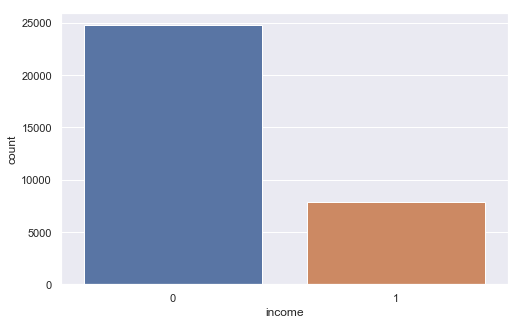

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(data['income'])

As one can see, there is considerable class imbalance in the target variable, i.e. income. This is also intuitively obvious as one expects fewer 'rich' people (earning>50k/annum) than 'not-so-rich' people (earning <50k/annum). Therefore we might need to consider over-sampling techniques in our ML model to improve our accuracy.

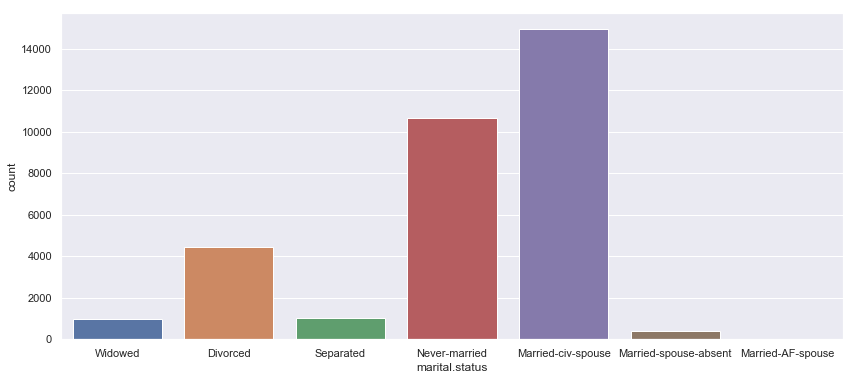

In [13]:
plt.figure(figsize=(14,6))
sns.countplot(data['marital.status'])

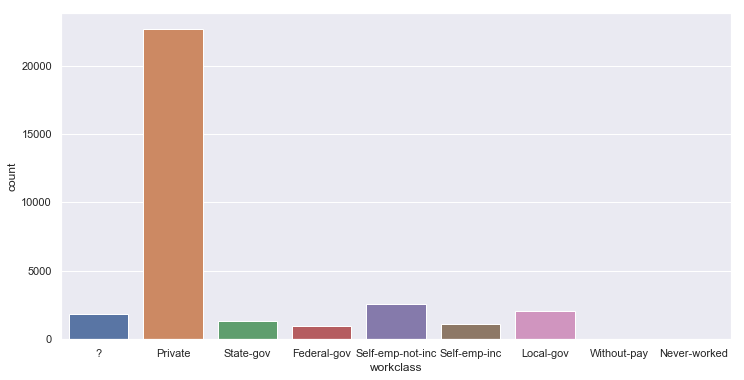

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(data['workclass'])

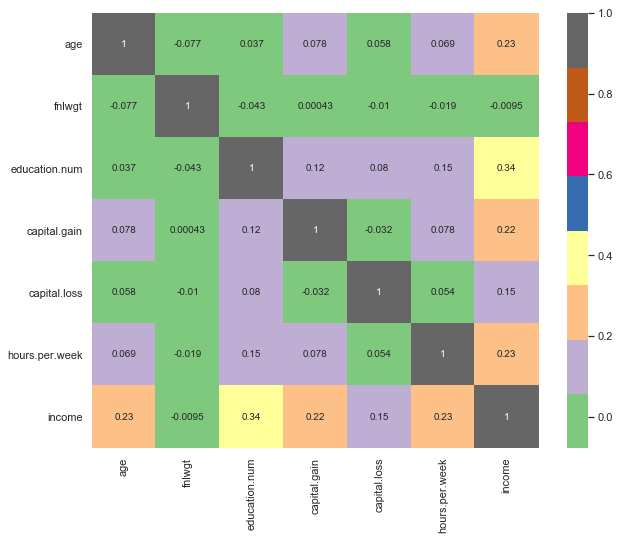

In [15]:
plt.figure(figsize=(10,8))  
sns.heatmap(data.corr(),cmap='Accent',annot=True)
#data.corr()

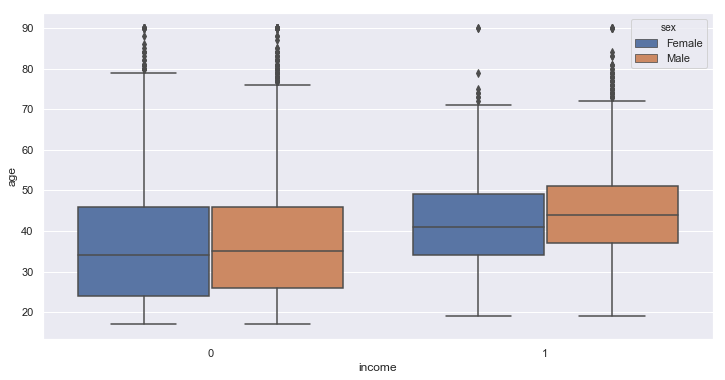

In [16]:
plt.figure(figsize=(12,6))
sns.boxplot(x="income", y="age", data=data, hue='sex')
#data[data['income']==0]['age'].mean()

The mean age of people earning more than 50k per annum is around 44 whereas the mean age of of those earning less than 50k per annum is 36.

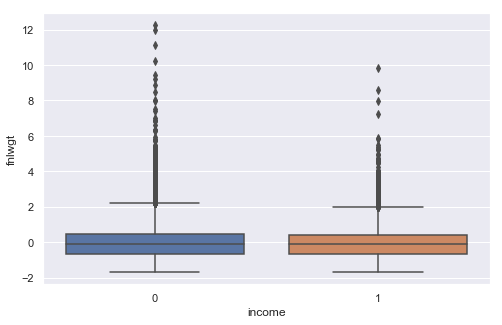

In [17]:
norm_fnl = (data["fnlwgt"] - data['fnlwgt'].mean())/data['fnlwgt'].std()
plt.figure(figsize=(8,5))
sns.boxplot(x="income", y=norm_fnl, data=data)

As evident from the plot above, there are many outliers in the `fnlwgt` column and this feature is uncorrelated with `income`, our target variable. The correlation coefficient (which one can read from the heatmap) is -0.0095. The number of outliers, i.e. the number of records which are more than 2 s.d's away from the mean, is 1249.

In [18]:
data[norm_fnl>2].shape

(1249, 15)

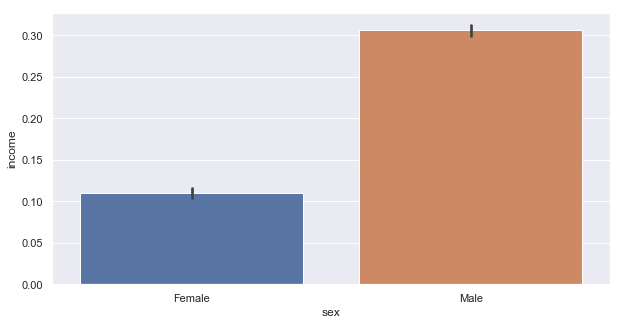

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(x='sex',y='income',data=data)

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital.status, dtype: int64

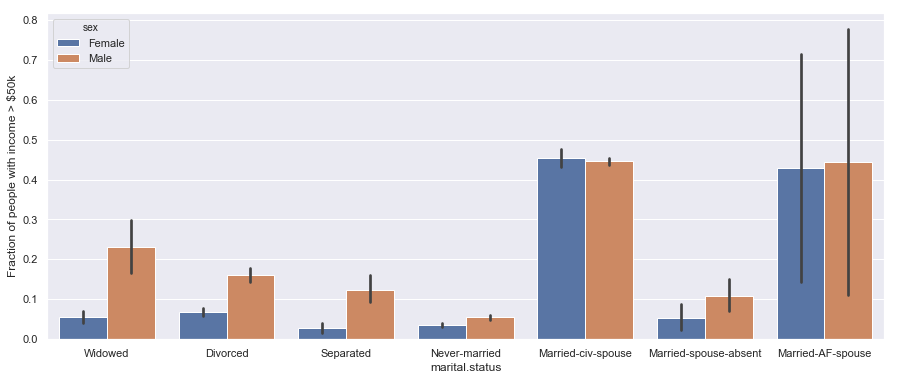

In [20]:
plt.figure(figsize=(15,6))
ax=sns.barplot(x='marital.status',y='income',data=data,hue='sex')
ax.set(ylabel='Fraction of people with income > $50k')
data['marital.status'].value_counts()

The above plot shows the the fraction of people earning more than $50k per annum, grouped by their marital status and gender. The data shows that married people have a higher %age of high-earners, compared to those who either never married or are widowed/divorced/separated. The black lines indicate 2 standard deviations (or 95\% confidence interval) in the data set. The married spouses of armed forces personnel have a much higher variation in their income compared to civil spouses because of low-number statistics.

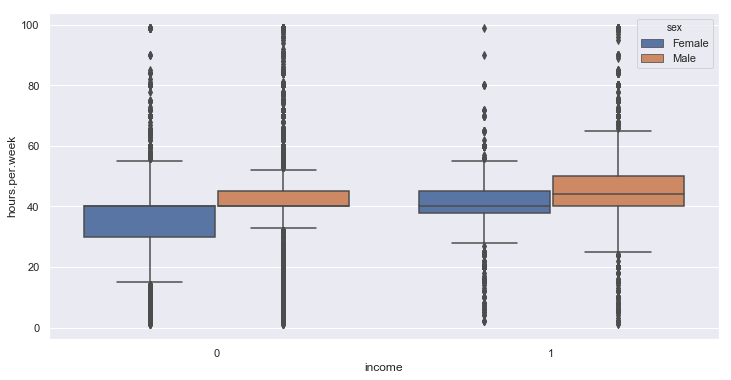

In [21]:
plt.figure(figsize=(12,6))
sns.boxplot(x='income',y ='hours.per.week', hue='sex',data=data)

[Text(0, 0.5, 'mean hours per week')]

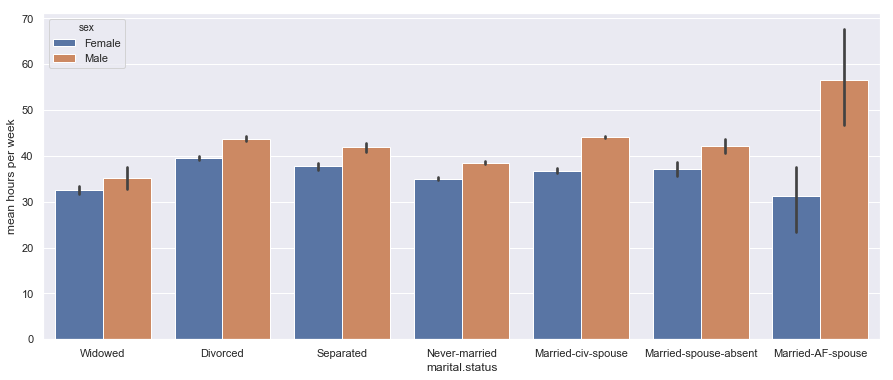

In [22]:
plt.figure(figsize=(15,6))
ax = sns.barplot(x='marital.status',y='hours.per.week',data=data,hue='sex')
ax.set(ylabel='mean hours per week')

[Text(0, 0.5, 'Mean education')]

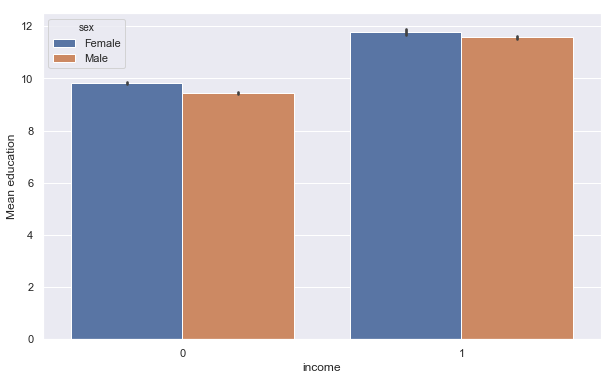

In [23]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x='income', y='education.num',hue='sex', data=data)
ax.set(ylabel='Mean education')

The `education.num` is label encoded such that a higher number corresponds to a higher level of education. As on would naïvely expect, people who earn more (>50k per annum) are also highly educated. The mean education level for `income=1` class is between 11 (Assoc-voc) and 12 (Assoc-acdm) whereas that for the `income=0` class is between 9 (HS-grad) and 10 (Some-college).

White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


[Text(0, 0.5, 'Fraction of people with income > $50k')]

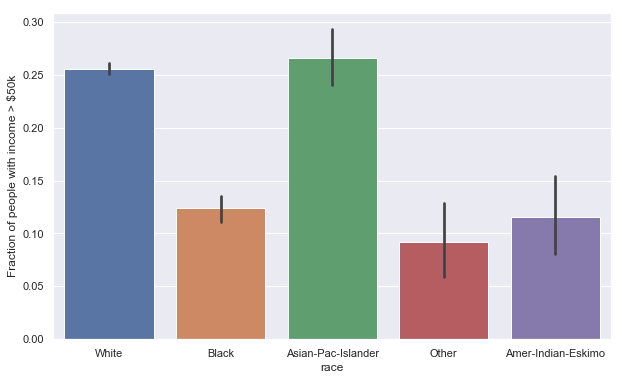

In [24]:
print(data['race'].value_counts())
plt.figure(figsize=(10,6))
ax=sns.barplot(x='race',y='income',data=data)
ax.set(ylabel='Fraction of people with income > $50k')

[Text(0, 0.5, 'Fraction of people with income > $50k')]

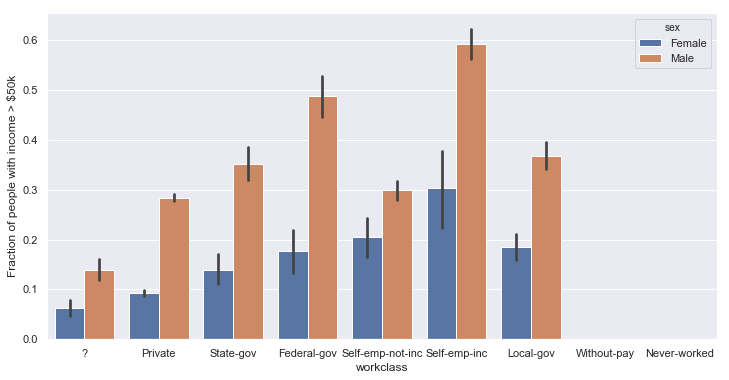

In [25]:
plt.figure(figsize=(12,6))
ax=sns.barplot('workclass', y='income', data=data, hue='sex')
ax.set(ylabel='Fraction of people with income > $50k')

<Figure size 864x432 with 0 Axes>

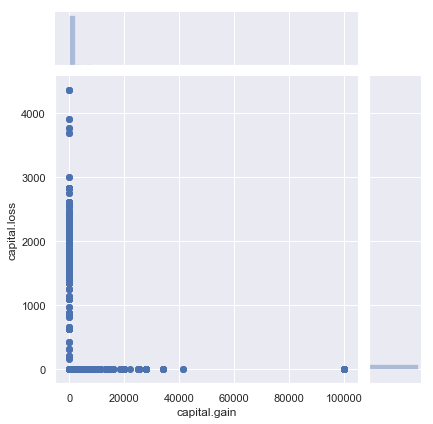

In [26]:
plt.figure(figsize=(12,6))
sns.jointplot(x=data['capital.gain'], y=data['capital.loss'])
#print(data[((data['capital.gain']!=0) & (data['capital.loss']!=0))].shape)

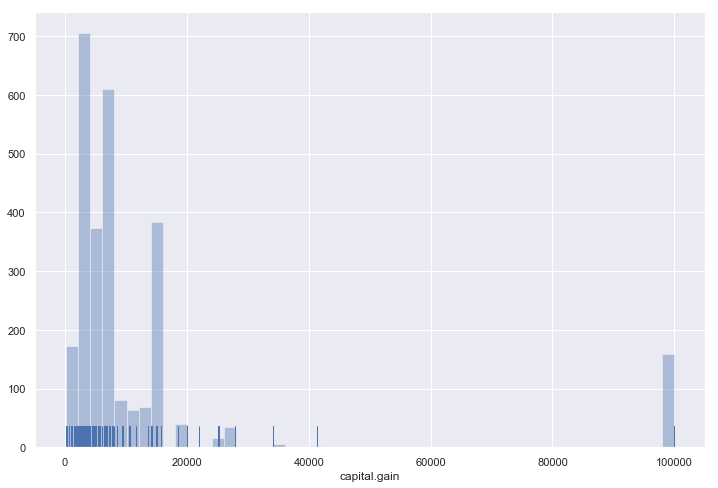

In [27]:
plt.figure(figsize=(12,8))
sns.distplot(data[(data['capital.gain']!=0)]['capital.gain'],kde=False, rug=True)

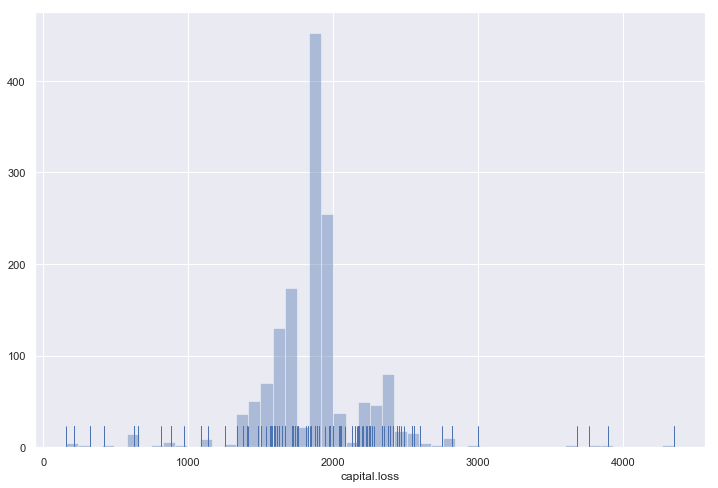

In [28]:
plt.figure(figsize=(12,8))
sns.distplot(data[(data['capital.loss']!=0)]['capital.loss'], kde=False,rug=True)

[Text(0, 0.5, 'Fraction of people with income > $50k')]

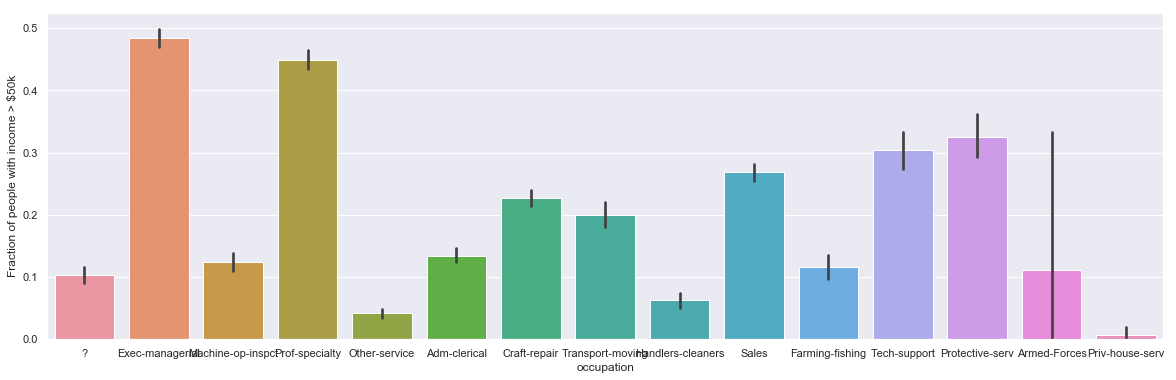

In [29]:
plt.figure(figsize=(20,6))
ax=sns.barplot(x='occupation', y='income', data=data)
ax.set(ylabel='Fraction of people with income > $50k')

In [30]:
print(data['native.country'].value_counts())
not_from_US = np.sum(data['native.country']!='United-States')
print(not_from_US, 'people are not from the United States')

United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                        34
Peru                             31
Greece                      

In [31]:
# Convert the native.country feature to binary since there is a huge imbalance in this feature
data['native.country'] = (data['native.country']=='United-States')*1

In [32]:
data.select_dtypes(exclude=[np.number]).head()

,workclass,education,marital.status,occupation,relationship,race,sex
0,?,HS-grad,Widowed,?,Not-in-family,White,Female
1,Private,HS-grad,Widowed,Exec-managerial,Not-in-family,White,Female
2,?,Some-college,Widowed,?,Unmarried,Black,Female
3,Private,7th-8th,Divorced,Machine-op-inspct,Unmarried,White,Female
4,Private,Some-college,Separated,Prof-specialty,Own-child,White,Female


In [33]:
data = data.applymap(lambda x: np.nan if x=='?' else x) #Replace all '?'s with NaNs.

In [34]:
data.isnull().sum(axis=0)

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country       0
income               0
dtype: int64

In [35]:
data.shape[0] - data.dropna(axis=0).shape[0]   # how many rows will be removed if I remove all the NaN's?

1843

In [36]:
data = data.dropna(axis=0) ## Drop all the NaNs

In [37]:
#data.education.value_counts()  # I will label-encode the education column since it is an ordinal categorical variable

In [38]:
## This computes the fraction of people by country who earn >50k per annum
#mean_income_bycountry_df = data[['native.country','income']].groupby(['native.country']).mean().reset_index()

In [39]:
#edu_encode_dict = {'Preschool':0,'1st-4th':1, '5th-6th':2, '7th-8th':3, '9th':4, '10th':5,
#                  '11th':6, '12th':7, 'HS-grad':8, 'Some-college':9, 'Bachelors':10, 'Masters':11, 'Assoc-voc':12, 
#                   'Assoc-acdm':13, 'Doctorate':14, 'Prof-school':15}

#data['education'] = data['education'].apply(lambda ed_level: edu_encode_dict[ed_level])

### One-hot encoding of the categorical columns

In [40]:
data = pd.get_dummies(data,columns=['workclass','sex', 'marital.status',
                                    'race','relationship','occupation'],
               prefix=['workclass', 'is', 'is', 'race_is', 'relation', 'is'], drop_first=True)
### native country is ignored because that feature will be dropped later

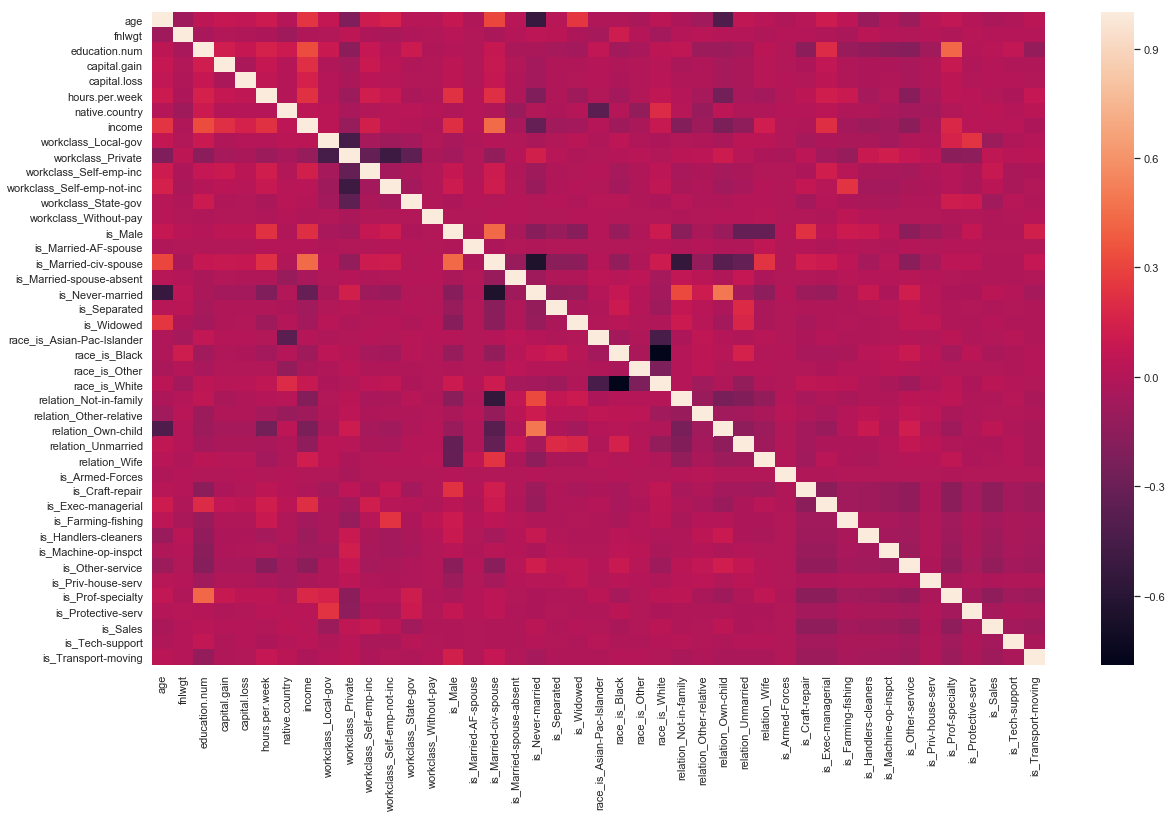

In [41]:
plt.figure(figsize=(20,12))
sns.heatmap(data.corr())

In [42]:
data.select_dtypes(exclude=[np.number]).shape

(30718, 1)

In [43]:
#data['foo']=np.where(data['native.country']=='United-States',1,0)

In [44]:
data.groupby('income').mean()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,native.country,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,is_Farming-fishing,is_Handlers-cleaners,is_Machine-op-inspct,is_Other-service,is_Priv-house-serv,is_Prof-specialty,is_Protective-serv,is_Sales,is_Tech-support,is_Transport-moving
income,,,,,,,,,,,,,,,,,,,,,
0,36.612190,190419.176782,9.636509,148.055618,53.528524,39.371900,0.889067,0.063985,0.768727,0.021415,...,0.038105,0.055662,0.075949,0.136900,0.006416,0.098882,0.018987,0.115615,0.027961,0.055358
1,43.966013,188115.803660,11.619346,3994.758170,195.601046,45.705882,0.914379,0.080654,0.648758,0.081307,...,0.015033,0.011242,0.032680,0.017908,0.000131,0.243007,0.027582,0.128497,0.036993,0.041830


In [45]:
data.shape

(30718, 44)

In [46]:
y = data.income
X = data.drop(['income', 'education', 'native.country', 'fnlwgt'],axis=1)

- `income` is dropped from X because it is the target variable.
- `Education` is dropped because it is already label-encoded in `education.num`. One can notice the high correlation between `education` and `education.num` in the heatmap.
- `native country` is dropped because it showed very little feature importance in random forest classifer.
- `fnlwgt` is dropped because it has no correlation with `income`.

## Modelling
This section explores different classification algorithms to maximise the accuracy for predicting income of a person (> 50k/yr or < 50k/yr).

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier as xgb
from sklearn import metrics

### Baseline model
In the baseline model, we predict the minority class for all our train and test (or validation) examples. The resulting accuracy will serve as a benchmark for the ML models. In other words, the sophisticated ML models should have an accuracy which should at least better the baseline one.

In [50]:
baseline_train = np.zeros(y_train.shape[0])
baseline_test = np.zeros(y_test.shape[0])
print('Accuracy on train data: %f%%' % (metrics.accuracy_score(y_train, baseline_train)))
print('Accuracy on test data: %f%%' %  (metrics.accuracy_score(y_test, baseline_test)))

Accuracy on train data: 0.750442%
Accuracy on test data: 0.752170%


### Random Forest classifier

In [51]:
rfmodel = RandomForestClassifier(n_estimators=300,oob_score=True,min_samples_split=5, max_depth=10,random_state=10)
rfmodel.fit(X_train,y_train)
print(rfmodel)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)


In [52]:
def show_classifier_metrics(clf, y_train=y_train,y_test=y_test, print_classification_report=True, print_confusion_matrix=True):
    print(clf)
    if print_confusion_matrix:
        print('confusion matrix of training data')
        print(metrics.confusion_matrix(y_train, clf.predict(X_train)))
        print('confusion matrix of test data')
        print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
    if print_classification_report:
        print('classification report of test data')
        print(metrics.classification_report(y_test, clf.predict(X_test)))
    print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, clf.predict(X_test))*100))
    print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, clf.predict(X_train))*100))
    print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, clf.predict(X_test))))

In [53]:
show_classifier_metrics(rfmodel,y_train)
print('oob score = %f'% rfmodel.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)
confusion matrix of training data
[[15456   680]
 [ 2246  3120]]
confusion matrix of test data
[[6641  291]
 [1046 1238]]
classification report of test data
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      6932
           1       0.81      0.54      0.65      2284

    accuracy                           0.85      9216
   macro avg       0.84      0.75      0.78      9216
weighted avg       0.85      0.85      0.84      9216

Accuracy on test data: 85.4926

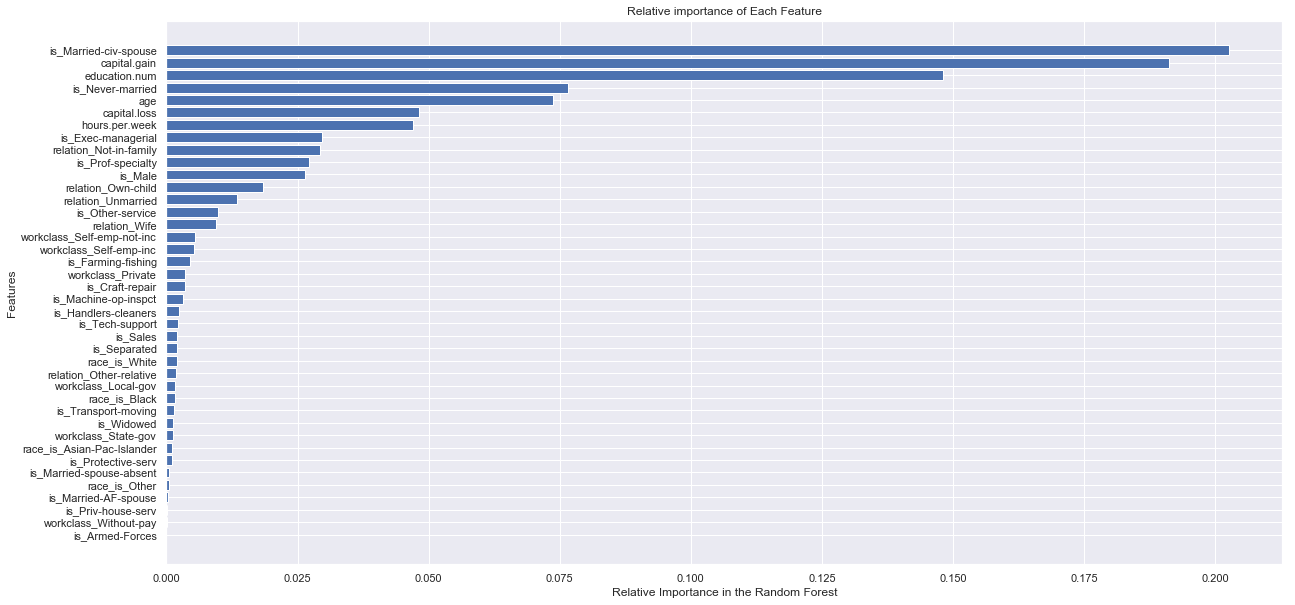

In [54]:
importance_list = rfmodel.feature_importances_
name_list = X_train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(20,10))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Random forest: Grid Search and cross-validation

In [55]:
from sklearn.model_selection import cross_val_score, GridSearchCV

In [56]:
def grid_search(clf, parameters, X, y, n_jobs= -1, n_folds=4, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =2)
    else:
        print('Doing grid search')
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds, verbose =2)
    gs.fit(X, y)
    print("mean test score (weighted by split size) of CV rounds: ",gs.cv_results_['mean_test_score'] )
    print ("Best parameter set", gs.best_params_, "Corresponding mean CV score",gs.best_score_)
    best = gs.best_estimator_
    return best

In [57]:
rfmodel2 = RandomForestClassifier(min_samples_split=5,oob_score=True, n_jobs=-1,random_state=10)
parameters = {'n_estimators': [100,200,300], 'max_depth': [10,13,15,20]}
rfmodelCV = grid_search(rfmodel2, parameters,X_train,y_train)

Doing grid search
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.2min finished


mean test score (weighted by split size) of CV rounds:  [0.85610641 0.85582736 0.85601339 0.85805972 0.85768766 0.85754814
 0.85810622 0.85838527 0.85833876 0.85912938 0.85912938 0.85982699]
Best parameter set {'max_depth': 20, 'n_estimators': 300} Corresponding mean CV score 0.8598269928378756


In [58]:
rfmodelCV.fit(X_train,y_train)
show_classifier_metrics(rfmodelCV,y_train)
print('oob score = %f'% rfmodelCV.oob_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=True, random_state=10, verbose=0,
                       warm_start=False)
confusion matrix of training data
[[15613   523]
 [ 1483  3883]]
confusion matrix of test data
[[6557  375]
 [ 921 1363]]
classification report of test data
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6932
           1       0.78      0.60      0.68      2284

    accuracy                           0.86      9216
   macro avg       0.83      0.77      0.79      9216
weighted avg       0.85      0.86      0.85      9216

Accuracy on test data: 85.937500

## XGBoost 

In [59]:
from xgboost.sklearn import XGBClassifier

In [60]:
param = {}
param['learning_rate'] = 0.1
param['verbosity'] = 1
param['colsample_bylevel'] = 0.9
param['colsample_bytree'] = 0.9
param['subsample'] = 0.9
param['reg_lambda']= 1.5
param['max_depth'] = 5
param['n_estimators'] = 400
param['seed']=10
xgb= XGBClassifier(**param)
xgb.fit(X_train, y_train, eval_metric=['error'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.150684	validation_1-error:0.152778
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.149102	validation_1-error:0.151693
[2]	validation_0-error:0.150498	validation_1-error:0.152561
[3]	validation_0-error:0.14873	validation_1-error:0.152018
[4]	validation_0-error:0.149149	validation_1-error:0.151259
[5]	validation_0-error:0.149428	validation_1-error:0.151584
[6]	validation_0-error:0.149102	validation_1-error:0.152018
[7]	validation_0-error:0.14873	validation_1-error:0.150825
[8]	validation_0-error:0.148079	validation_1-error:0.150499
[9]	validation_0-error:0.14794	validation_1-error:0.150391
[10]	validation_0-error:0.147893	validation_1-error:0.151259
[11]	validation_0-error:0.148033	validation_1-error:0.150282
[12]	validation_0-error:0.145707	validation_1-error:0.150174
[13]	validation_0-error:0.145568	validation_1-error:0.14963

[132]	validation_0-error:0.122128	validation_1-error:0.131619
[133]	validation_0-error:0.122035	validation_1-error:0.13151
[134]	validation_0-error:0.121896	validation_1-error:0.13151
[135]	validation_0-error:0.121989	validation_1-error:0.131293
[136]	validation_0-error:0.122175	validation_1-error:0.131293
[137]	validation_0-error:0.122268	validation_1-error:0.131402
[138]	validation_0-error:0.122128	validation_1-error:0.131293
[139]	validation_0-error:0.122128	validation_1-error:0.131185
[140]	validation_0-error:0.121896	validation_1-error:0.131293
[141]	validation_0-error:0.121896	validation_1-error:0.131402
[142]	validation_0-error:0.121942	validation_1-error:0.130968
[143]	validation_0-error:0.121896	validation_1-error:0.131076
[144]	validation_0-error:0.121942	validation_1-error:0.130968
[145]	validation_0-error:0.121989	validation_1-error:0.131185
[146]	validation_0-error:0.121849	validation_1-error:0.130859
[147]	validation_0-error:0.122082	validation_1-error:0.130968
[148]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9, verbosity=1)

In [61]:
show_classifier_metrics(xgb,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9, verbosity=1)
confusion matrix of training data
[[15241   895]
 [ 1703  3663]]
confusion matrix of test data
[[6552  380]
 [ 813 1471]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6932
           1       0.79      0.64      0.71      2284

    accuracy                           0.87      9216
   macro avg       0.84      0.79      0.81      9216
weighted avg       0.87      0.87      0.87      9216

Accuracy on test data: 87.055122%
Accuracy on training data:

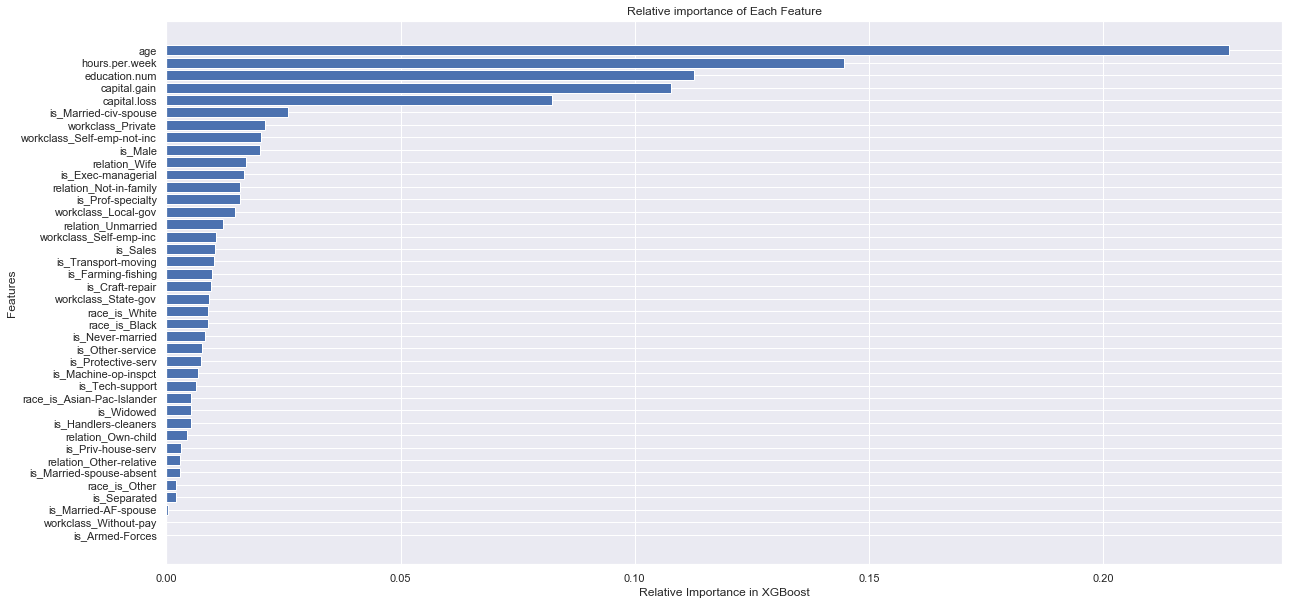

In [62]:
importance_list = xgb.feature_importances_
name_list = X_train.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.figure(figsize=(20,10))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in XGBoost')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

### Grid search with cross validation: XGBoost model

In [63]:
xgbmodel2 = XGBClassifier(seed=42)
param = {
'learning_rate': [0.1],
#'verbosity': [1],
'colsample_bylevel': [0.9],
'colsample_bytree': [0.9],
'subsample' : [0.9],
'n_estimators': [300],
'reg_lambda': [1.5,2],
'max_depth': [3,5,7],
 'seed': [10]   
}
xgbCV = grid_search(xgbmodel2, param,X_train,y_train)

Doing grid search
Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.5min finished


mean test score (weighted by split size) of CV rounds:  [0.86745419 0.86661706 0.86875639 0.86982606 0.86461724 0.86554739]
Best parameter set {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'reg_lambda': 2, 'seed': 10, 'subsample': 0.9} Corresponding mean CV score 0.8698260626918426


In [64]:
xgbCV.fit(X_train, y_train, eval_metric=['error'], eval_set=[(X_train, y_train),(X_test, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.150684	validation_1-error:0.152778
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.149102	validation_1-error:0.151693
[2]	validation_0-error:0.150498	validation_1-error:0.152561
[3]	validation_0-error:0.14873	validation_1-error:0.152018
[4]	validation_0-error:0.149195	validation_1-error:0.151259
[5]	validation_0-error:0.149288	validation_1-error:0.151259
[6]	validation_0-error:0.149102	validation_1-error:0.15191
[7]	validation_0-error:0.148684	validation_1-error:0.150716
[8]	validation_0-error:0.147986	validation_1-error:0.150065
[9]	validation_0-error:0.147986	validation_1-error:0.150065
[10]	validation_0-error:0.14794	validation_1-error:0.151042
[11]	validation_0-error:0.148079	validation_1-error:0.150391
[12]	validation_0-error:0.145707	validation_1-error:0.149957
[13]	validation_0-error:0.145242	validation_1-error:0.14974

[132]	validation_0-error:0.123384	validation_1-error:0.132053
[133]	validation_0-error:0.123477	validation_1-error:0.132487
[134]	validation_0-error:0.123244	validation_1-error:0.131727
[135]	validation_0-error:0.123105	validation_1-error:0.131836
[136]	validation_0-error:0.122733	validation_1-error:0.132053
[137]	validation_0-error:0.122919	validation_1-error:0.131619
[138]	validation_0-error:0.12264	validation_1-error:0.131185
[139]	validation_0-error:0.12264	validation_1-error:0.131185
[140]	validation_0-error:0.122872	validation_1-error:0.131293
[141]	validation_0-error:0.122779	validation_1-error:0.131619
[142]	validation_0-error:0.12264	validation_1-error:0.131727
[143]	validation_0-error:0.122686	validation_1-error:0.131727
[144]	validation_0-error:0.122686	validation_1-error:0.131944
[145]	validation_0-error:0.12264	validation_1-error:0.131727
[146]	validation_0-error:0.122593	validation_1-error:0.131619
[147]	validation_0-error:0.1225	validation_1-error:0.131727
[148]	validati

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=2, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9)

In [65]:
show_classifier_metrics(xgbCV,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=2, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9)
confusion matrix of training data
[[15248   888]
 [ 1749  3617]]
confusion matrix of test data
[[6549  383]
 [ 826 1458]]
classification report of test data
              precision    recall  f1-score   support

           0       0.89      0.94      0.92      6932
           1       0.79      0.64      0.71      2284

    accuracy                           0.87      9216
   macro avg       0.84      0.79      0.81      9216
weighted avg       0.86      0.87      0.86      9216

Accuracy on test data: 86.881510%
Accuracy on training data: 87.736025%
Are

In [66]:
#X_test.iloc[np.where(y_test != xgbCV.predict(X_test))]

## Logistic regression

In [67]:
from sklearn.linear_model import LogisticRegression

In [68]:
logreg = LogisticRegression(C=0.8,random_state=42,max_iter=200)
logreg.fit(X_train, y_train)

/Users/debashis/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
show_classifier_metrics(logreg)

LogisticRegression(C=0.8, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
confusion matrix of training data
[[14953  1183]
 [ 2092  3274]]
confusion matrix of test data
[[6424  508]
 [ 924 1360]]
classification report of test data
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6932
           1       0.73      0.60      0.66      2284

    accuracy                           0.84      9216
   macro avg       0.80      0.76      0.78      9216
weighted avg       0.84      0.84      0.84      9216

Accuracy on test data: 84.461806%
Accuracy on training data: 84.768859%
Area under the ROC curve : 0.761082


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
NBmodel = GaussianNB()

In [ ]:
NBmodel.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
NBmodel.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
show_classifier_metrics(NBmodel,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)
confusion matrix of training data
[[13743  2393]
 [ 1409  3957]]
confusion matrix of test data
[[5935  997]
 [ 642 1642]]
classification report of test data
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      6932
           1       0.62      0.72      0.67      2284

    accuracy                           0.82      9216
   macro avg       0.76      0.79      0.77      9216
weighted avg       0.83      0.82      0.83      9216

Accuracy on test data: 82.215712%
Accuracy on training data: 82.317924%
Area under the ROC curve : 0.787544


### Stacked model

In [ ]:
def create_stacked_dataset(clfs,modelnames, X_train=X_train,X_test=X_test):
    X_train_stack, X_test_stack = X_train, X_test
    for clf,modelname in zip(clfs,modelnames):
        temptrain = pd.DataFrame(clf.predict(X_train),index = X_train.index,columns=[modelname+'_prediction'])
        temptest  = pd.DataFrame(clf.predict(X_test),index = X_test.index,columns=[modelname+'_prediction'])
        X_train_stack = pd.concat([X_train_stack, temptrain], axis=1)
        X_test_stack = pd.concat([X_test_stack, temptest], axis=1)
    return (X_train_stack,X_test_stack)

In [ ]:
X_train_stack,X_test_stack = create_stacked_dataset([NBmodel,rfmodel,logreg,xgb],modelnames=['NBmodel','rfmodel','logreg','xgb'])

In [ ]:
X_train_stack.head(2)

,age,education.num,capital.gain,capital.loss,hours.per.week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,is_Priv-house-serv,is_Prof-specialty,is_Protective-serv,is_Sales,is_Tech-support,is_Transport-moving,NBmodel_prediction,rfmodel_prediction,logreg_prediction,xgb_prediction
31369,36,10,0,0,60,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31013,20,6,0,0,40,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
param = {}
param['learning_rate'] = 0.1
param['verbosity'] = 1
param['colsample_bylevel'] = 0.9
param['colsample_bytree'] = 0.9
param['subsample'] = 0.9
param['reg_lambda']= 1.5
param['max_depth'] = 5#10
param['n_estimators'] = 400
param['seed']=10
xgbstack= XGBClassifier(**param)
xgbstack.fit(X_train_stack, y_train, eval_metric=['error'], eval_set=[(X_train_stack, y_train),(X_test_stack, y_test)],early_stopping_rounds=30)


[0]	validation_0-error:0.12064	validation_1-error:0.129774
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.120733	validation_1-error:0.129666
[2]	validation_0-error:0.120733	validation_1-error:0.129666
[3]	validation_0-error:0.120826	validation_1-error:0.129449
[4]	validation_0-error:0.120826	validation_1-error:0.129449
[5]	validation_0-error:0.120826	validation_1-error:0.129449
[6]	validation_0-error:0.120826	validation_1-error:0.129449
[7]	validation_0-error:0.120826	validation_1-error:0.129449
[8]	validation_0-error:0.120826	validation_1-error:0.129449
[9]	validation_0-error:0.120826	validation_1-error:0.129449
[10]	validation_0-error:0.120779	validation_1-error:0.129449
[11]	validation_0-error:0.120779	validation_1-error:0.129449
[12]	validation_0-error:0.120686	validation_1-error:0.129557
[13]	validation_0-error:0.120779	validation_1-error:0.129

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=400, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9, verbosity=1)

In [ ]:
print(metrics.classification_report(y_test, xgbstack.predict(X_test_stack)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, xgbstack.predict(X_test_stack))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, xgbstack.predict(X_train_stack))*100))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6932
           1       0.79      0.64      0.71      2284

    accuracy                           0.87      9216
   macro avg       0.84      0.79      0.81      9216
weighted avg       0.87      0.87      0.87      9216

Accuracy on test data: 87.055122%
Accuracy on training data: 87.917403%


### Stacked model Grid Search

In [ ]:
xgbstackCV = XGBClassifier(seed=10)
param_grid = {}
param_grid['learning_rate'] = [0.1]
param_grid['colsample_bylevel'] = [0.9]
param_grid['colsample_bytree'] = [0.9]
param_grid['subsample'] = [0.9]
param_grid['n_estimators'] = [300]
param_grid['reg_lambda']= [1.5]
param_grid['seed'] =[10]
param_grid['max_depth'] = [3,5,8,10]
xgbstackCV_grid = grid_search(xgbstackCV, param_grid,X_train_stack,y_train)

Doing grid search
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:  1.5min finished


mean test score (weighted by split size) of CV rounds:  [0.87824388 0.87503488 0.86805879 0.86280346]
Best parameter set {'colsample_bylevel': 0.9, 'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'reg_lambda': 1.5, 'seed': 10, 'subsample': 0.9} Corresponding mean CV score 0.8782438842898335


In [ ]:
xgbstackCV_grid.fit(X_train_stack, y_train, eval_metric=['error'], eval_set=[(X_train_stack, y_train),(X_test_stack, y_test)],early_stopping_rounds=30)

[0]	validation_0-error:0.120826	validation_1-error:0.129449
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 30 rounds.
[1]	validation_0-error:0.120826	validation_1-error:0.129449
[2]	validation_0-error:0.120826	validation_1-error:0.129449
[3]	validation_0-error:0.120826	validation_1-error:0.129449
[4]	validation_0-error:0.120826	validation_1-error:0.129449
[5]	validation_0-error:0.120826	validation_1-error:0.129449
[6]	validation_0-error:0.120826	validation_1-error:0.129449
[7]	validation_0-error:0.120826	validation_1-error:0.129449
[8]	validation_0-error:0.120826	validation_1-error:0.129449
[9]	validation_0-error:0.120826	validation_1-error:0.129449
[10]	validation_0-error:0.120826	validation_1-error:0.129449
[11]	validation_0-error:0.120826	validation_1-error:0.129449
[12]	validation_0-error:0.120826	validation_1-error:0.129449
[13]	validation_0-error:0.120826	validation_1-error:0.12

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
              colsample_bytree=0.9, gamma=0, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=300, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1.5, scale_pos_weight=1, seed=10, silent=True,
              subsample=0.9)

In [ ]:
print(metrics.classification_report(y_test, xgbstack.predict(X_test_stack)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, xgbstack.predict(X_test_stack))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train, xgbstack.predict(X_train_stack))*100))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6932
           1       0.79      0.64      0.71      2284

    accuracy                           0.87      9216
   macro avg       0.84      0.79      0.81      9216
weighted avg       0.87      0.87      0.87      9216

Accuracy on test data: 87.055122%
Accuracy on training data: 87.917403%


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
catb = CatBoostClassifier(learning_rate=0.1,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy',rsm=0.9)

In [ ]:
catb.fit(X_train,y_train,eval_set=[(X_train,y_train), (X_test,y_test)],early_stopping_rounds=30)

0:	learn: 0.8371779	test: 0.8371779	test1: 0.8371311	best: 0.8371311 (0)	total: 195ms	remaining: 1m 17s
1:	learn: 0.8440610	test: 0.8440610	test1: 0.8403863	best: 0.8403863 (1)	total: 333ms	remaining: 1m 6s
2:	learn: 0.8460608	test: 0.8460608	test1: 0.8440755	best: 0.8440755 (2)	total: 419ms	remaining: 55.5s
3:	learn: 0.8455027	test: 0.8455027	test1: 0.8446181	best: 0.8446181 (3)	total: 467ms	remaining: 46.3s
4:	learn: 0.8466189	test: 0.8466189	test1: 0.8457031	best: 0.8457031 (4)	total: 511ms	remaining: 40.4s
5:	learn: 0.8480606	test: 0.8480606	test1: 0.8468967	best: 0.8468967 (5)	total: 549ms	remaining: 36s
6:	learn: 0.8477816	test: 0.8477816	test1: 0.8457031	best: 0.8468967 (5)	total: 606ms	remaining: 34s
7:	learn: 0.8478281	test: 0.8478281	test1: 0.8464627	best: 0.8468967 (5)	total: 678ms	remaining: 33.2s
8:	learn: 0.8476886	test: 0.8476886	test1: 0.8457031	best: 0.8468967 (5)	total: 757ms	remaining: 32.9s
9:	learn: 0.8479211	test: 0.8479211	test1: 0.8463542	best: 0.8468967 (5)	tot

In [ ]:
show_classifier_metrics(catb)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
np.sum(y_train)/y_train.shape[0]

In [ ]:
ros = RandomOverSampler(random_state=1,sampling_strategy='auto')

In [ ]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
catb_ros = CatBoostClassifier(learning_rate=0.1,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy')

In [ ]:
catb_ros.fit(X_resampled,y_resampled,eval_set=[(X_resampled,y_resampled), (X_test,y_test)],early_stopping_rounds=30)

In [ ]:
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, catb_ros.predict(X_test))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_resampled, catb_ros.predict(X_resampled))*100))
print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, catb_ros.predict(X_test))))

### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
smt = SMOTE(random_state=10,sampling_strategy=0.7)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

In [ ]:
y_train.value_counts()

In [ ]:
np.bincount(y_train_smt)

In [ ]:
catb_smote = CatBoostClassifier(learning_rate=0.1,iterations=400,verbose=1,random_seed=10,eval_metric='Accuracy')

In [ ]:
catb_smote.fit(X_train_smt,y_train_smt,eval_set=[(X_train_smt,y_train_smt), (X_test,y_test)],early_stopping_rounds=30)

In [ ]:
print(metrics.classification_report(y_test, catb_smote.predict(X_test)))
print('Accuracy on test data: %f%%' % (metrics.accuracy_score(y_test, catb_smote.predict(X_test))*100))
print('Accuracy on training data: %f%%' % (metrics.accuracy_score(y_train_smt, catb_smote.predict(X_train_smt))*100))
print('Area under the ROC curve : %f' % (metrics.roc_auc_score(y_test, catb_ros.predict(X_test))))